In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LassoCV, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_regression, RFE

import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
data = pd.read_csv("../data/healthy_train.csv")
data.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,alcohol_intake_frequency,blood_pressure_diastolic,blood_pressure_systolic,mean_reaction_time,drug_consumption,alcohol_consumption,spine_bone_mineral_density,spine_bone_area,grey_matter_volume,white_matter_volume
0,0.009370,-0.060801,0.095221,-0.067210,-0.010655,-0.022006,0.019152,0.011319,0.016343,-0.075556,...,3.0,87.0,139.0,514.0,0.0,2.0,1.02114,172.482,666708.0,1429.0
1,0.011861,-0.059949,0.090284,-0.072400,-0.003142,-0.016716,0.021362,0.010305,0.004759,-0.079706,...,2.0,80.0,136.0,534.0,1.0,2.0,1.13242,199.805,582085.0,3440.0
2,-0.006793,-0.062545,0.115140,-0.066756,-0.013463,0.000917,0.032148,0.001175,0.021150,-0.105033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.000253,-0.053957,0.105223,-0.065367,-0.016815,-0.014960,0.024741,0.012980,0.013445,-0.090042,...,2.0,NaN,NaN,534.0,1.0,2.0,0.92736,190.287,645029.0,1893.0
4,0.023904,-0.050469,0.097732,-0.070295,-0.014627,-0.014779,0.019980,0.015485,0.014482,-0.077255,...,2.0,63.0,109.0,498.0,0.0,2.0,1.07134,192.917,673670.0,746.0


In [5]:
dropcols = ['spine_bone_mineral_density', 'spine_bone_area','blood_pressure_systolic','blood_pressure_diastolic']

data = data.drop(columns=dropcols)


# try to predict the age
data = data.dropna()
print(data.shape)
X = data.drop(columns=["age"])
y = data["age"]


z_scores = np.abs(zscore(X))
non_outliers = ~np.any(z_scores > 4, axis=1)
X = X[non_outliers]
y = y[non_outliers]


scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    # Lasso regression model
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Lasso Regression MAE: {mae:.2f}, R^2: {r2:.2f}")
    # ElasticNet regression model
    elastic_net = ElasticNetCV(cv=5, random_state=42)
    elastic_net.fit(X_train, y_train)
    
    y_pred_en = elastic_net.predict(X_test)
    mae_en = mean_absolute_error(y_test, y_pred_en)
    r2_en = r2_score(y_test, y_pred_en)
    print(f"ElasticNet Regression MAE: {mae_en:.2f}, R^2: {r2_en:.2f}")
    # Linear regression model
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)
    
    y_pred_lr = linear_reg.predict(X_test)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    print(f"Linear Regression MAE: {mae_lr:.2f}, R^2: {r2_lr:.2f}")


(915, 1035)
Lasso Regression MAE: 3.10, R^2: 0.66
ElasticNet Regression MAE: 3.03, R^2: 0.67
Linear Regression MAE: 4.91, R^2: 0.09


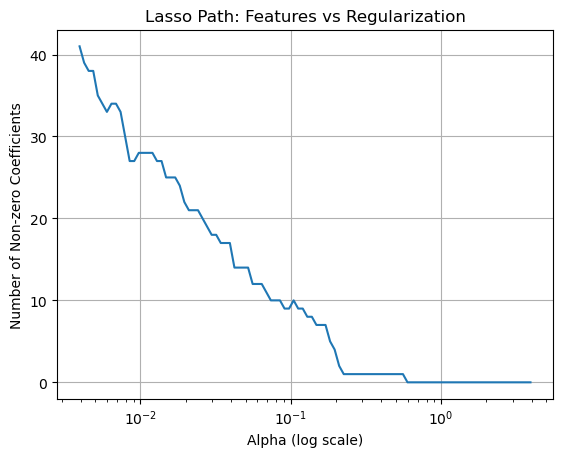

In [6]:

alphas = np.logspace(-0.5, 1, 100)
plt.plot(lasso.alphas_, np.count_nonzero(lasso.path(X, y, alphas=alphas, max_iter=100000)[1], axis=0))
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Number of Non-zero Coefficients")
plt.title("Lasso Path: Features vs Regularization")
plt.grid(True)
plt.show()

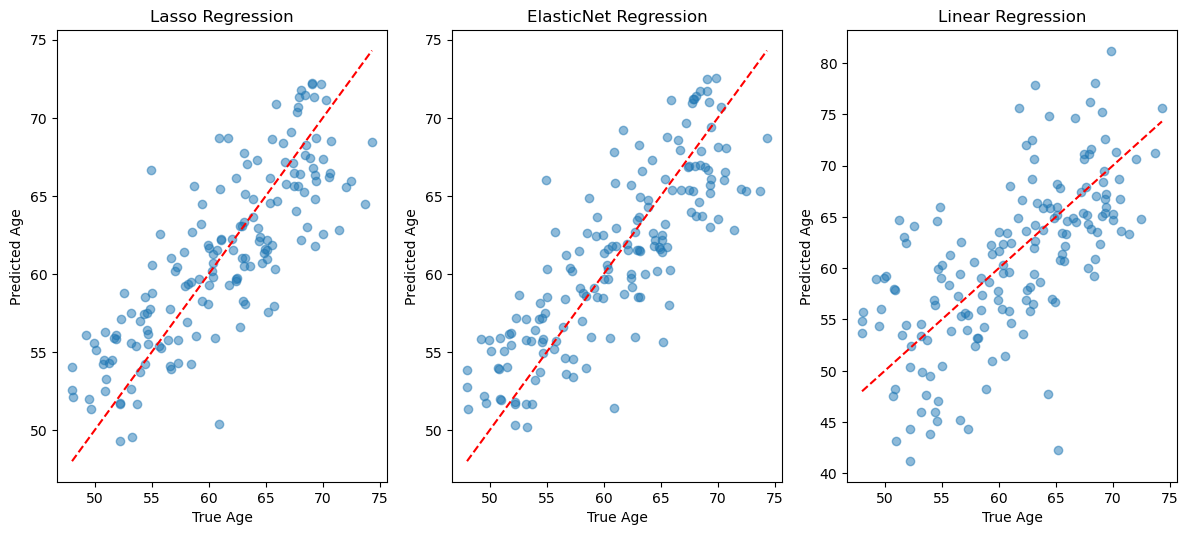

In [7]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Lasso Regression')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_en, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('ElasticNet Regression')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

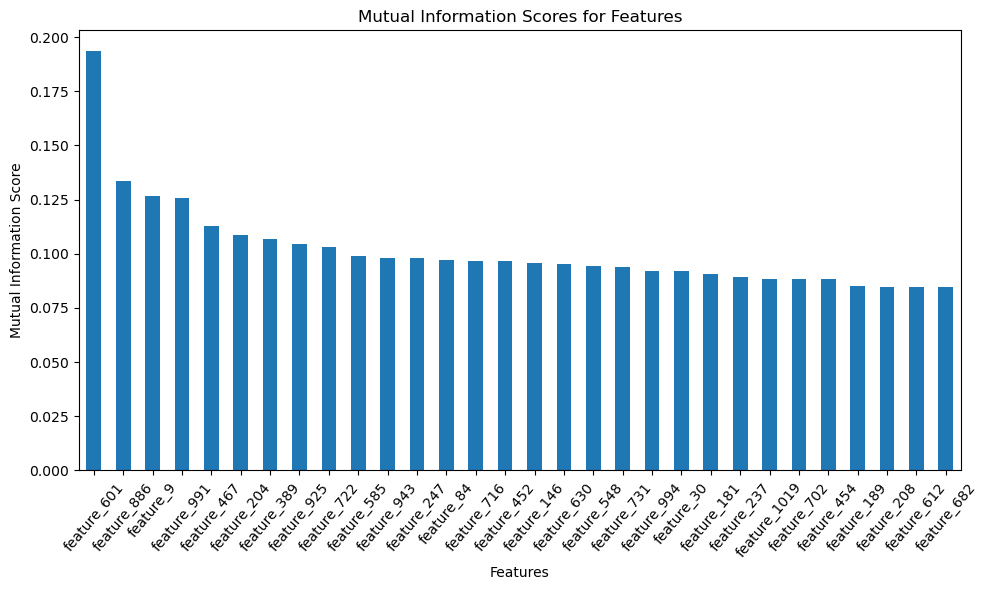

In [8]:
# top features by mutual information
mi_scores = mutual_info_regression(X_train, y_train)
mi_scores = pd.Series(mi_scores, index=data.drop(columns=["age"]).columns)
mi_scores = mi_scores.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
mi_scores[:30].plot(kind='bar')
plt.title('Mutual Information Scores for Features')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

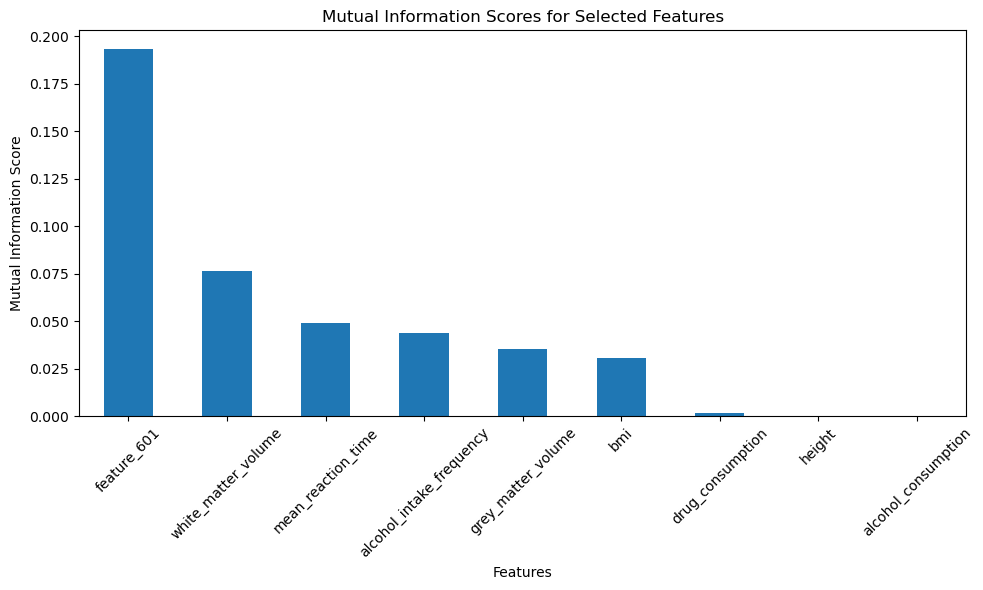

In [9]:
# get all columns without feature_ in the name
feature_columns = [col for col in data.columns if 'feature_' not in col]
feature_columns.remove('age')
feature_columns.remove('eid')


mi_scores_subset = mi_scores[feature_columns + ['feature_601']].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
mi_scores_subset.plot(kind='bar')
plt.title('Mutual Information Scores for Selected Features')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
lasso_coef = pd.Series(lasso.coef_, index=data.drop(columns=["age"]).columns)
print(f"Total features: {len(lasso_coef)}")
lasso_coef = lasso_coef[lasso_coef != 0].sort_values(ascending=False)
selected_lasso = lasso_coef[lasso_coef != 0].index.tolist()

print(f"Selected {len(selected_lasso)} features by Lasso Regression")
print("Non MAE features selected:")
for feature in selected_lasso:
    if not "feature" in feature:
        print(f"\t{feature}: {lasso_coef[feature]:.4f}")

print("Top 15 features selected by Lasso Regression:")
for feature in selected_lasso[:15]:
    print(f"\t{feature}: {lasso_coef[feature]:.4f}")

# save feature names 
with open("../simple_test/top_features.txt", "w") as f:
    for feature in selected_lasso:
        f.write(f"{feature}\n")

Total features: 1034
Selected 72 features by Lasso Regression
Non MAE features selected:
	white_matter_volume: 0.9965
	mean_reaction_time: 0.2616
	alcohol_consumption: 0.0168
	alcohol_intake_frequency: -0.0780
	drug_consumption: -0.1636
	height: -0.5192
	grey_matter_volume: -0.9705
Top 15 features selected by Lasso Regression:
	feature_601: 1.6262
	feature_943: 1.1523
	white_matter_volume: 0.9965
	feature_637: 0.7247
	feature_126: 0.6545
	feature_1004: 0.6304
	feature_295: 0.5449
	feature_487: 0.5331
	feature_986: 0.4846
	feature_988: 0.4676
	feature_367: 0.4149
	feature_96: 0.3885
	feature_132: 0.3642
	feature_147: 0.3510
	feature_274: 0.3089


In [2]:
combined_data = pd.read_csv("../data/radiomics_embeddings_wat.csv")
combined_data.head(2)

/tmp/ipykernel_3979416/1416924380.py:1: DtypeWarning: Columns (7600,7601,7602,7603,7604,7605,7606,7607,7608,7609,7610,7611,7612,7613,7614,7615,7616,7617,7618,7619,7620,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_data = pd.read_csv("../data/radiomics_embeddings_wat.csv")


,spleen_shape_Elongation,spleen_shape_Flatness,spleen_shape_LeastAxisLength,spleen_shape_MajorAxisLength,spleen_shape_Maximum2DDiameterColumn,spleen_shape_Maximum2DDiameterRow,spleen_shape_Maximum2DDiameterSlice,spleen_shape_Maximum3DDiameter,spleen_shape_MeshVolume,spleen_shape_MinorAxisLength,...,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023,feature_1024
0,0.701211,0.359204,12.162694,33.860105,36.400549,37.121422,25.553865,37.336309,6339.833333,23.743064,...,0.010315,0.027598,-0.020467,0.051751,0.067062,0.045957,-0.011000,-0.107336,0.021400,-0.001287
1,0.637994,0.328238,14.973817,45.618803,44.777226,47.413078,36.687873,49.839743,12187.250000,29.104517,...,0.003139,0.018993,-0.002491,0.051269,0.054192,0.045861,-0.013209,-0.108935,0.034711,-0.012152


In [4]:
print(combined_data.shape)

# na columns with more than x% missing values
x = 0.3
na_cols = combined_data.columns[combined_data.isna().mean() > x]
combined_data_nona = combined_data.drop(columns=na_cols)
print(combined_data_nona.shape)
combined_data_nona = combined_data_nona.dropna()
print(combined_data_nona.shape)
# non float values
non_float_cols = combined_data_nona.select_dtypes(exclude=[np.float64, np.int64]).columns
print(f"Non float columns: {non_float_cols.tolist()}")
# drop non float columns
combined_data_nona = combined_data_nona.drop(columns=non_float_cols)


(13230, 8673)
(13230, 8519)
(11560, 8519)
Non float columns: ['unused_exception']


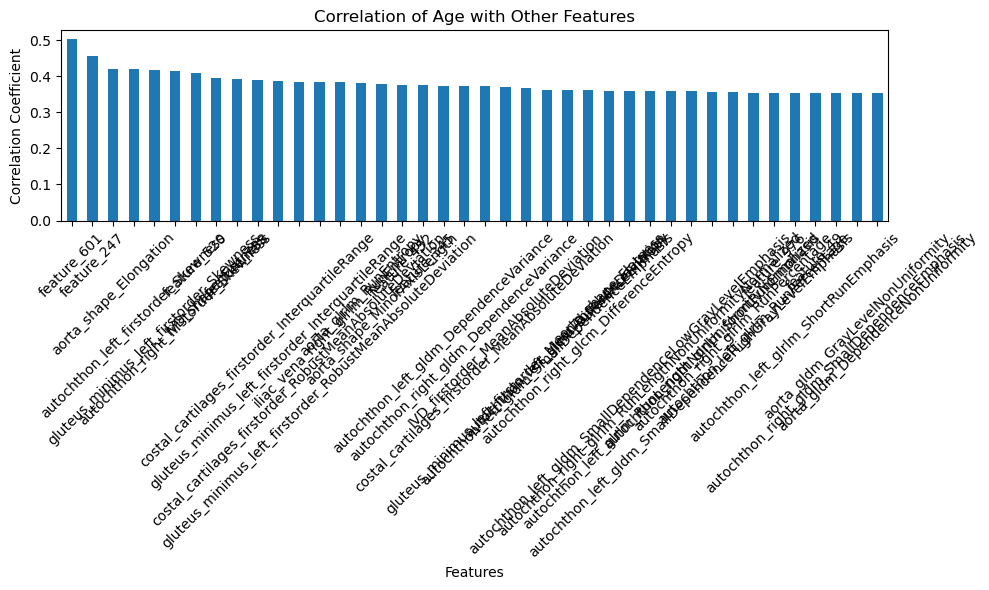

In [5]:
# correlation of age column with other columns using corrwith
data_age = combined_data_nona['age']
data_other = combined_data_nona.drop(columns=['age'])
correlation = data_other.corrwith(data_age).sort_values(ascending=False)

# plot the correlation
plt.figure(figsize=(10, 6))
correlation[:40].plot(kind='bar')
plt.title('Correlation of Age with Other Features')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# store top 500 features
top_features = correlation.index[:500].tolist()
# save top features
with open("../simple_test/top_500.txt", "w") as f:
    for feature in top_features:
        f.write(f"{feature}\n")

feature_601                                                    0.502041
feature_247                                                    0.454750
aorta_shape_Elongation                                         0.421178
autochthon_left_firstorder_Skewness                            0.419984
gluteus_minimus_left_firstorder_Skewness                       0.416821
autochthon_right_firstorder_Skewness                           0.413947
feature_520                                                    0.409647
IVD_shape_Flatness                                             0.396268
feature_788                                                    0.393471
costal_cartilages_firstorder_InterquartileRange                0.390423
gluteus_minimus_left_firstorder_InterquartileRange             0.387768
costal_cartilages_firstorder_RobustMeanAbsoluteDeviation       0.384653
gluteus_minimus_left_firstorder_RobustMeanAbsoluteDeviation    0.383912
iliac_vena_right_glrlm_RunEntropy                              0

In [7]:
pca_features = pd.read_csv("./outfiles/pca_components.csv")
pca_features.head(2)

,eid,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC656,PC657,PC658,PC659,PC660,PC661,PC662,PC663,PC664,age
0,4631514,-27.292616,-4.64805,-1.605450,-3.750686,-22.335325,-19.189872,4.421732,2.139825,9.114578,...,0.620262,1.395400,-0.318438,-0.638195,0.319640,-0.954205,0.681053,-2.038928,-1.864419,79.5
1,4936786,80.237720,5.55432,5.581476,-3.128240,-14.420319,1.533556,13.465340,-2.291548,7.313545,...,0.270349,0.314989,1.229206,0.925971,0.255467,-0.159917,0.286283,0.415404,-0.257349,75.3
